In [1]:
from datasets import load_dataset
from LatentPixel import LatentLlama, TGraph, BIN_FONT
from tqdm import tqdm
import numpy as np
import re
import subprocess
import torch
import pandas as pd
import logging
loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
for logger in loggers:
    logger.setLevel(logging.ERROR)

/home/tai/data/miniconda3/envs/pixel/lib/python3.10/site-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(


In [2]:
pat = re.compile('([a-zA-Z]+)')
def add_word(words: str | list[str], corpus: set[str]):
    global pat
    if isinstance(words, str):
        words = re.findall(pat, words)

    for word in words:
        corpus.add(str(word).lower())
    return

def evaluate_babi(generated: list, vocab: set) -> dict[str, float]:
    pat = re.compile('^([a-zA-Z]*)')
    correct_paddle = 0
    correct_tess = 0
    corrects = 0
    n_readable = 0
    for idx in tqdm(range(len(generated))):
        cor = False
        readable = False
        pro = generated[idx][0]
        t: str = generated[idx][1]
        t = t.replace('g', 'q')
        g = generated[idx][2]
        img: TGraph = g[pro._num_text_patches[0]-1:g._num_text_patches[0]-1]
        text = img.ocr(method='paddleocr', square=False, span=True, span_ratio=1.3, scale=3)
        raw = text[0].lower().split()
        if len(raw) == 0:
            raw = ''
        else:
            raw = raw[0]  
        m = pat.match(text[0])
        if m is not None:
            text = m.groups()[0]
        else:
            text = ''
        if raw in vocab:
            readable = True
        text = text.replace('g', 'q')
        if text == t:
            correct_paddle += 1
            cor = True
        text = img.ocr(method='tesseract', square=False, span=True, span_ratio=1.3, scale=3)
        raw = text[0].lower().split()
        if len(raw) == 0:
            raw = ''
        else:
            raw = raw[0]  
        m = pat.match(text[0])
        if m is not None:
            text = m.groups()[0]
        else:
            text = ''
        if raw in vocab:
            readable = True
        text = text.replace('g', 'q')
        if text == t:
            correct_tess += 1
            cor = True
        if cor:
            corrects += 1
        if readable:
            n_readable += 1
    return {
        'paddleocr': correct_paddle / len(generated),
        'tesseract': correct_tess / len(generated),
        'union': corrects / len(generated),
        'readability': n_readable / len(generated) 
    }

def gen_babi(task_id: int, num: int, prompt: str, after_prompt: str) -> tuple[str, str]:
    pat = re.compile("(^[0-9]*) ([^\t]*)(?:\t(.*)\t)*")

    raw = subprocess.run(['babi-tasks', f'{task_id}', f'{num}'], stdout=subprocess.PIPE).stdout.decode()
    lines = list(map(lambda x: x.groups(), map(pat.match, raw.splitlines())))
    # return lines
    results = []
    cur_sample = []
    for line in lines:
        if line[0] == '1':
            results.append(cur_sample) if len(cur_sample) > 0 else ...
            cur_sample = []
        cur_sample.append(line[1])
        if line[2] is not None:
            cur_sample.append(prompt)
            cur_sample.append(line[2] + after_prompt)
    results.append(cur_sample)
    data = []
    for sample in results:
        prompt = ' '.join(sample[:-1])
        target = sample[-1]
        data.append((prompt, target))
    return data


In [3]:
corpo = pd.read_csv('storage/unigram_freq.csv')
vocab = set()
add_word(corpo.word.tolist()[:3000], vocab)


In [4]:
'''
Yintao's devbox environment
'''
_ =TGraph.init_render(
    dpi=80,
    font_file=BIN_FONT,
    font_size=8,
    pixels_per_patch=8,
    rgb=False,
    binary=True,
    max_seq_length=800,
    patch_len=2
)
model = LatentLlama(
    backbone_path='storage/checkpoints/1MModels/dllama_2_b/backbone',
    num_channels=1,
    patch_len=2,
    patch_size=8,
    binary=True
)

Coder path is none, do not load compressor for this model


In [5]:
data = gen_babi(1, 1000, '|', '')
for a, b in data:
    add_word(a, vocab)
    add_word(b, vocab)
    
print(len(vocab))

with torch.no_grad():
    model.eval()
    model.cuda()
    generated = []
    for prompt, target in tqdm(data):
        prompt = TGraph.from_text([prompt])
        prompt = prompt._spacing_text(3)
        prompt.set_device('cuda')
        gen = model.autoregressive_generate(prompt, None, 4)
        prompt.set_device('cpu')
        gen.set_device('cpu')
        generated.append((prompt, target, gen))


3005


100%|██████████| 1000/1000 [00:39<00:00, 25.29it/s]


In [6]:
evaluate_babi(generated, vocab)

100%|██████████| 1000/1000 [04:00<00:00,  4.16it/s]


{'paddleocr': 0.083, 'tesseract': 0.105, 'union': 0.111, 'readability': 0.437}

bedroom


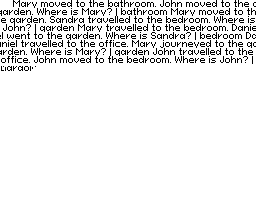

In [69]:
idx = 45
print(generated[idx][1])
generated[idx][2].to_PIL()[0]

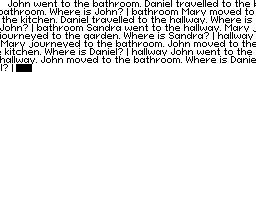

In [436]:
generated[idx][0].to_PIL()[0]

In [420]:
pat = re.compile('^([a-zA-Z]*)')
pro = generated[idx][0]
t = generated[idx][1]
g = generated[idx][2]
img: TGraph = g[pro._num_text_patches[0]-1:g._num_text_patches[0]-1]
text = img.ocr(method='tesseract', square=False, span=True, span_ratio=1.3, scale=3)
m = pat.match(text[0])
if m is not None:
    text = m.groups()[0]
else:
    text = ''
print("Predictions:",text,"\nTarget:", t)

Predictions: boew 
Target: office


In [438]:
generated[0]

(<LatentPixel.text_graph.TGraph at 0x7fe69a0e33d0>,
 'kitchen',
 <LatentPixel.text_graph.TGraph at 0x7fe69a0e1ff0>)

In [14]:
idx = 0
for p, t, g in generated:
    p: TGraph
    g: TGraph
    p.to_file(f'babi_samples/{idx}/prompt_{t}.png', binary_method='gray_scale')
    g.to_file(f'babi_samples/{idx}/generated_{t}.png', binary_method='gray_scale')
    idx += 1

In [7]:
g._value

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]], device='cuda:0')

In [87]:
data = gen_babi(1, 1000, 'Answer:', '')
for a, b in data:
    add_word(a, vocab)
    add_word(b, vocab)

model.eval()
model.cuda()
generated = []
for prompt, target in tqdm(data):
    prompt = TGraph.from_text([prompt])
    prompt = prompt._spacing_text(3)
    prompt.set_device('cuda')
    gen = model.autoregressive_generate(prompt, None, 4)
    prompt.set_device('cpu')
    gen.set_device('cpu')
    generated.append((prompt, target, gen))
evaluate_babi(generated, vocab)

100%|██████████| 1000/1000 [03:58<00:00,  4.19it/s]


{'paddleocr': 0.006, 'tesseract': 0.009, 'union': 0.009, 'readability': 0.092}

In [88]:
data = gen_babi(1, 1000, '|', '')
for a, b in data:
    add_word(a, vocab)
    add_word(b, vocab)

model.eval()
model.cuda()
generated = []
for prompt, target in tqdm(data):
    prompt = TGraph.from_text([prompt])
    prompt = prompt._spacing_text(3)
    prompt.set_device('cuda')
    gen = model.autoregressive_generate(prompt, None, 4)
    prompt.set_device('cpu')
    gen.set_device('cpu')
    generated.append((prompt, target, gen))
evaluate_babi(generated, vocab)

100%|██████████| 1000/1000 [03:54<00:00,  4.26it/s]


{'paddleocr': 0.06, 'tesseract': 0.073, 'union': 0.084, 'readability': 0.374}

In [89]:
data = gen_babi(1, 1000, '', '')
for a, b in data:
    add_word(a, vocab)
    add_word(b, vocab)

model.eval()
model.cuda()
generated = []
for prompt, target in tqdm(data):
    prompt = TGraph.from_text([prompt])
    prompt = prompt._spacing_text(3)
    prompt.set_device('cuda')
    gen = model.autoregressive_generate(prompt, None, 4)
    prompt.set_device('cpu')
    gen.set_device('cpu')
    generated.append((prompt, target, gen))
evaluate_babi(generated, vocab)

100%|██████████| 1000/1000 [03:56<00:00,  4.22it/s]


{'paddleocr': 0.002, 'tesseract': 0.003, 'union': 0.003, 'readability': 0.17}